# Goal

The goal of this colab is to train a CNN on the IBM-NASA dataset for crop clasification.

# Installation

This module is dedicated for the installation of required packages for the usage of this collab.

In [4]:
!pip install segmentation-models-pytorch torch torchvision torchmetrics datasets albumentations rasterio tqdm pandas

# Imports

In [5]:
import os
import rasterio
import copy
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
import time
import json


import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from segmentation_models_pytorch import DeepLabV3Plus
from segmentation_models_pytorch.losses import FocalLoss, TverskyLoss
from torch.utils.tensorboard import SummaryWriter


import pandas as pd

from torchmetrics.classification import Accuracy, JaccardIndex
from torchmetrics.segmentation import DiceScore, MeanIoU

from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.transforms import ToTensor
from functools import lru_cache
from tqdm import tqdm

# Dataset loading
from datasets import load_dataset

# Google Drive Configuration

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Configuration

This block of code will configure all the requried global variables for the project. Some of this variables may have to be changed base on the user so make sure to check them out before executing the program.

In [7]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 14

# Trainign
EPOCHS = 50
BATCH_SIZE = 32

# Loading
NUM_WORKERS = 0

# Model params
ENCODER_NAME = "resnet34"
ENCODER_WEIGHTS = None
LEARNING_RATE = 1e-4
DECODER_ATTENTION_TYPE = "scse"
DECODER_USER_NORM = False

# Data directories
DATA_DIR = "/content/drive/MyDrive/Universidad/TFG/Implementations/nasa_ibm/"
UNET_MODEL_FOLDER  = "/content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/DeepLabV3+/models/"
UNET_GRAPH_FOLDER  = "/content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/DeepLabV3+/graphs/"
UNET_METRICS_FOLDER  = "/content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/DeepLabV3+/metrics/"

SPLIT_DIR = DATA_DIR + "splited"

TRAINING_IMAGE_DIR = DATA_DIR + "training_chips_merged"
TRAINING_MASK_DIR = DATA_DIR + "training_chips_mask"

VALIDATION_IMAGE_DIR = DATA_DIR + "training_chips_merged"
VALIDATION_MASK_DIR = DATA_DIR + "training_chips_mask"

TEST_IMAGE_DIR = DATA_DIR + "test_chips_merged"
TEST_MASK_DIR = DATA_DIR + "test_chips_mask"

In [8]:
class HFDGeoDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, image_dir, mask_dir, transform=None, is_original_dataset = True ):
        self.dataset = hf_dataset
        self.to_tensor = ToTensor()
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        self.chip_ids = [item['text'] for item in self.dataset]

        self.image_paths = [os.path.join(image_dir, f"{chip_id}_merged.tif")
                           for chip_id in self.chip_ids]
        self.mask_paths = [os.path.join(mask_dir, f"{chip_id}.mask.tif")
                          for chip_id in self.chip_ids]


        self.use_memmap = True

    def __len__(self):
        return len(self.dataset)

    @lru_cache(maxsize=128)  # Cache recently accessed items
    def _load_image(self, image_path):
        """Load image with caching for repeated access."""
        try:
            with rasterio.open(image_path) as src:
                if self.use_memmap:
                    # Try memory-mapped reading when possible
                    image = src.read(out_shape=src.shape, masked=False)
                else:
                    image = src.read()
                return torch.from_numpy(image).type(torch.FloatTensor)
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            # Return empty tensor or handle error appropriately
            return torch.zeros((18, 224, 224), dtype=torch.float32)

    @lru_cache(maxsize=128)
    def _load_mask(self, mask_path):
        try:
            with rasterio.open(mask_path) as chip_mask:
                mask = chip_mask.read(1)
                return torch.from_numpy(mask).type(torch.LongTensor)
        except Exception as e:
            print(f"Error loading mask {mask_path}: {e}")
            return torch.zeros((224, 224), dtype=torch.long)

    def _normalize_per_band(self, image):
        normalized = np.zeros_like(image, dtype=np.float32)

        for i in range(image.shape[0]):
            band = image[i]
            band_min = band.min()
            band_max = band.max()

            if band_max > band_min:
                normalized[i] = ((band - band_min)/(band_max - band_min))
            else:
                normalized[i] = np.zeros_like(band)

        return torch.from_numpy(normalized).float()

    def __getitem__(self, idx):
        chip_id = self.dataset[idx]['text']
        image_path = self.image_paths[idx]
        mask_path  = self.mask_paths[idx]

        image = self._load_image(image_path)
        mask  = self._load_mask(mask_path)

        image = self._normalize_per_band(image)


        return image, mask





def create_datasets(dataset, image_dirs, mask_dirs, transform = None):
    # Create train and validation datasets
    train_dataset = HFDGeoDataset(
        dataset['train'],
        image_dir=image_dirs,
        mask_dir=mask_dirs,
        transform=transform
    )

    val_dataset = HFDGeoDataset(
        dataset['validation'],
        image_dir=image_dirs,
        mask_dir=mask_dirs,
        transform=transform
    )

    return train_dataset, val_dataset

def create_data_loaders(train_dataset, val_dataset, batch_size=BATCH_SIZE, ):
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=False,
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
    )

    return train_loader, val_loader


def visualize_random_rgb_sample(dataset, bands=(2, 1, 0), figsize=(10, 5)):
    """
    Picks a random sample and displays specified bands as an RGB composite,
    with per-band min/max normalization for proper visibility.

    Args:
        dataset: your HFDGeoDataset instance
        bands (tuple of int): which bands to use for R, G, B
        figsize (tuple): figure size in inches
    """
    # 1) Pick a random index
    idx = random.randint(0, len(dataset) - 1)
    image, mask = dataset[idx]       # image: Tensor[18, H, W], mask: Tensor[H, W]

    # 2) Select just the three bands and convert to a HxWx3 NumPy array
    img_bands = image[list(bands), ...]            # shape = (3, H, W)
    img_np = img_bands.permute(1, 2, 0).numpy()    # shape = (H, W, 3)

    print( image )

    # 3) Per-band min/max normalization
    for c in range(3):
        band = img_np[..., c]
        mn, mx = band.min(), band.max()
        img_np[..., c] = (band - mn) / (mx - mn + 1e-6)

    # 4) Plot side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    ax1.imshow(img_np)
    ax1.set_title(f"Sample #{idx} RGB (bands {bands})")
    ax1.axis("off")

    ax2.imshow(mask.numpy(), cmap="gray")
    ax2.set_title("Mask")
    ax2.axis("off")

    plt.tight_layout()
    plt.show()

<ipython-input-8-ca4464871695>:57: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  normalized[i] = ((band - band_min)/(band_max - band_min))


tensor([[[0.0739, 0.0786, 0.0766,  ..., 0.0776, 0.0709, 0.0621],
         [0.0621, 0.0628, 0.0632,  ..., 0.0845, 0.0932, 0.0908],
         [0.0638, 0.0640, 0.0648,  ..., 0.0823, 0.0816, 0.0709],
         ...,
         [0.0875, 0.0414, 0.0390,  ..., 0.0386, 0.0437, 0.0567],
         [0.0504, 0.0457, 0.0660,  ..., 0.0416, 0.0431, 0.0526],
         [0.0638, 0.0853, 0.1060,  ..., 0.0443, 0.0410, 0.0508]],

        [[0.0834, 0.0890, 0.0887,  ..., 0.0653, 0.0614, 0.0541],
         [0.0831, 0.0847, 0.0838,  ..., 0.0723, 0.0862, 0.0852],
         [0.0852, 0.0866, 0.0862,  ..., 0.0693, 0.0689, 0.0592],
         ...,
         [0.0913, 0.0389, 0.0414,  ..., 0.0250, 0.0302, 0.0421],
         [0.0456, 0.0415, 0.0705,  ..., 0.0258, 0.0291, 0.0381],
         [0.0590, 0.0869, 0.1161,  ..., 0.0286, 0.0279, 0.0370]],

        [[0.1058, 0.1131, 0.1067,  ..., 0.0858, 0.0836, 0.0774],
         [0.0806, 0.0820, 0.0780,  ..., 0.0925, 0.1061, 0.1064],
         [0.0768, 0.0761, 0.0753,  ..., 0.0868, 0.0844, 0.

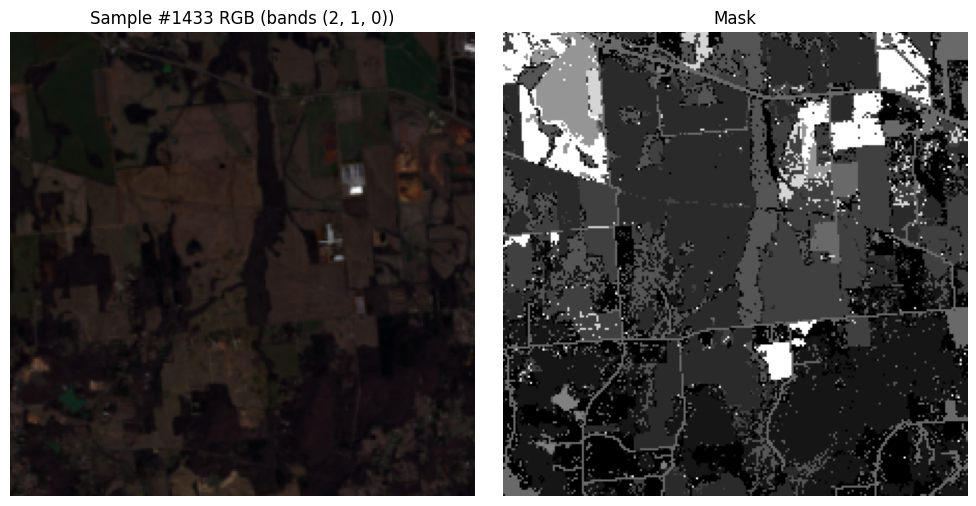

tensor([[[0.0674, 0.0521, 0.0445,  ..., 0.1947, 0.1931, 0.1778],
         [0.0510, 0.0409, 0.0395,  ..., 0.1972, 0.1950, 0.1838],
         [0.0845, 0.0532, 0.0453,  ..., 0.1980, 0.1942, 0.1879],
         ...,
         [0.2403, 0.2364, 0.2525,  ..., 0.0764, 0.0837, 0.0927],
         [0.2386, 0.2321, 0.2435,  ..., 0.0927, 0.0843, 0.0567],
         [0.2454, 0.2386, 0.2343,  ..., 0.0622, 0.0529, 0.0466]],

        [[0.0854, 0.0810, 0.0824,  ..., 0.1857, 0.1871, 0.1764],
         [0.0740, 0.0859, 0.0875,  ..., 0.1871, 0.1873, 0.1817],
         [0.1089, 0.0956, 0.0924,  ..., 0.1861, 0.1854, 0.1850],
         ...,
         [0.2799, 0.2822, 0.2871,  ..., 0.0996, 0.1073, 0.1124],
         [0.2792, 0.2755, 0.2813,  ..., 0.1084, 0.0961, 0.0754],
         [0.2855, 0.2799, 0.2771,  ..., 0.0845, 0.0782, 0.0786]],

        [[0.0737, 0.0514, 0.0347,  ..., 0.2362, 0.2407, 0.2197],
         [0.0414, 0.0323, 0.0276,  ..., 0.2391, 0.2405, 0.2268],
         [0.0823, 0.0463, 0.0343,  ..., 0.2370, 0.2364, 0.

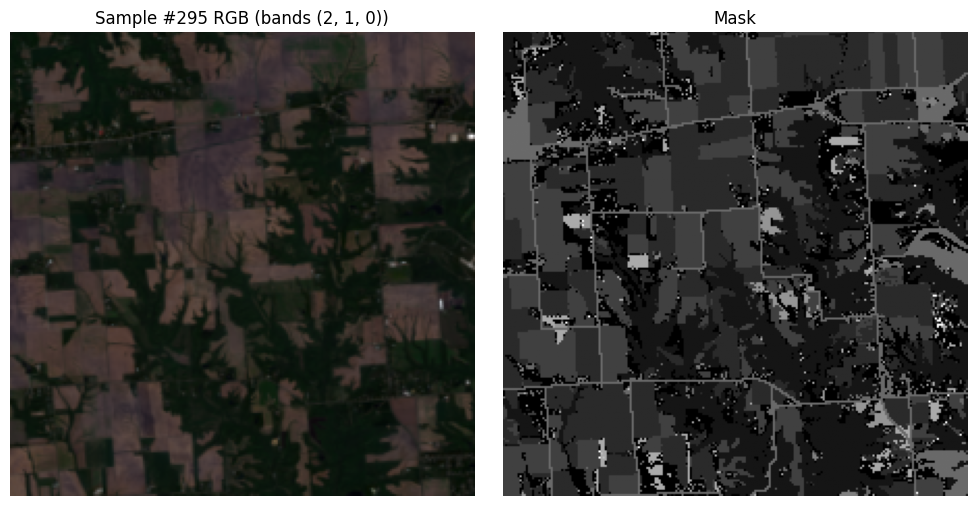

In [9]:
with open(os.path.join(SPLIT_DIR, 'dataset_splits.json')) as f:
    train_val_dataset = json.load(f)



# Create datasets
train_dataset, val_dataset = create_datasets(train_val_dataset, TRAINING_IMAGE_DIR, TRAINING_MASK_DIR)

# Create data loaders
train_loader, val_loader = create_data_loaders(train_dataset, val_dataset, batch_size=BATCH_SIZE)

visualize_random_rgb_sample(train_dataset)
visualize_random_rgb_sample(val_dataset)

In [10]:
model = DeepLabV3Plus(
    encoder_name=ENCODER_NAME,
    encoder_weights=ENCODER_WEIGHTS,
    in_channels=18,
    classes=NUM_CLASSES,
    decoder_attention_type=DECODER_ATTENTION_TYPE,
    decoder_use_norm=DECODER_USER_NORM
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

focal_loss = FocalLoss(mode="multiclass", gamma=2.0)
tversky_loss =  TverskyLoss(
    mode='multiclass',        # you have >2 semantic labels
    classes=None,             # include all classes; or e.g. [0,1,2,3] to pick a subset
    log_loss=False,           # use 1 – Tversky; you can switch to True if you prefer –log(Tversky)
    from_logits=True,         # DeepLabV3+ outputs raw logits
    ignore_index=0,           # often “255” is the void/background label in PASCAL VOC–style sets
    gamma=1.0                 # no extra focusing; >1 to emphasize hard/misaligned regions
)
ce_loss = nn.CrossEntropyLoss( ignore_index = 0 );


def criterion(preds, targets):
    """
    preds: raw logits,   shape [B, C, H, W]
    targets: integer labels, shape [B, H, W]
    """
    # ensure integer dtype
    targets = targets.long()

    L_trev = tversky_loss(preds, targets)

    return 1 * L_trev


scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
scaler = torch.cuda.amp.GradScaler()

<ipython-input-10-f61ae873a925>:38: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [11]:
accuracy = Accuracy(task="multiclass", average="macro",  num_classes=NUM_CLASSES).to(DEVICE)
iou = JaccardIndex(task="multiclass", num_classes=NUM_CLASSES).to(DEVICE)
dice = DiceScore( num_classes=NUM_CLASSES, average="macro",   input_format="index" ).to(DEVICE)
miou = MeanIoU(num_classes=NUM_CLASSES, include_background= False,  input_format="index"  ).to(DEVICE)

Epoch 1/50:   0%|          | 0/78 [00:00<?, ?it/s]<ipython-input-8-ca4464871695>:57: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  normalized[i] = ((band - band_min)/(band_max - band_min))
Epoch 1/50: 100%|██████████| 78/78 [10:04<00:00,  7.75s/it]


[Epoch  0] Loss:  0.8176, Acc:   0.1802, IoU:   0.0888, Dice:  0.0631, mIoU:  0.0452


Epoch 1/50 [Val]: 100%|██████████| 20/20 [01:46<00:00,  5.31s/it]


[Epoch  0] Loss: 0.7714, Acc: 0.2676, IoU: 0.1320, Dice: 0.0726, mIoU: 0.0565


Epoch 2/50: 100%|██████████| 78/78 [05:30<00:00,  4.24s/it]


[Epoch  1] Loss:  0.7268, Acc:   0.2833, IoU:   0.1679, Dice:  0.0890, mIoU:  0.0709


Epoch 2/50 [Val]: 100%|██████████| 20/20 [01:19<00:00,  3.96s/it]


[Epoch  1] Loss: 0.7071, Acc: 0.3003, IoU: 0.1800, Dice: 0.0992, mIoU: 0.0799


Epoch 3/50: 100%|██████████| 78/78 [05:56<00:00,  4.57s/it]


[Epoch  2] Loss:  0.6659, Acc:   0.3325, IoU:   0.2029, Dice:  0.1097, mIoU:  0.0887


Epoch 3/50 [Val]: 100%|██████████| 20/20 [01:41<00:00,  5.07s/it]


[Epoch  2] Loss: 0.6547, Acc: 0.3578, IoU: 0.2077, Dice: 0.1144, mIoU: 0.0932


Epoch 4/50: 100%|██████████| 78/78 [06:22<00:00,  4.91s/it]


[Epoch  3] Loss:  0.6358, Acc:   0.3557, IoU:   0.2211, Dice:  0.1260, mIoU:  0.1025


Epoch 4/50 [Val]: 100%|██████████| 20/20 [01:41<00:00,  5.08s/it]


[Epoch  3] Loss: 0.6469, Acc: 0.3471, IoU: 0.2137, Dice: 0.1266, mIoU: 0.1022


Epoch 5/50: 100%|██████████| 78/78 [06:17<00:00,  4.84s/it]


[Epoch  4] Loss:  0.6142, Acc:   0.3745, IoU:   0.2375, Dice:  0.1393, mIoU:  0.1133


Epoch 5/50 [Val]: 100%|██████████| 20/20 [01:39<00:00,  4.97s/it]


[Epoch  4] Loss: 0.6248, Acc: 0.3747, IoU: 0.2296, Dice: 0.1376, mIoU: 0.1122


Epoch 6/50: 100%|██████████| 78/78 [06:22<00:00,  4.91s/it]


[Epoch  5] Loss:  0.5959, Acc:   0.3878, IoU:   0.2512, Dice:  0.1518, mIoU:  0.1234


Epoch 6/50 [Val]: 100%|██████████| 20/20 [01:12<00:00,  3.61s/it]


[Epoch  5] Loss: 0.6135, Acc: 0.3690, IoU: 0.2427, Dice: 0.1528, mIoU: 0.1249


Epoch 7/50: 100%|██████████| 78/78 [06:56<00:00,  5.34s/it]


[Epoch  6] Loss:  0.5823, Acc:   0.4022, IoU:   0.2615, Dice:  0.1599, mIoU:  0.1306


Epoch 7/50 [Val]: 100%|██████████| 20/20 [01:08<00:00,  3.44s/it]


[Epoch  6] Loss: 0.6277, Acc: 0.3570, IoU: 0.2273, Dice: 0.1405, mIoU: 0.1136


Epoch 8/50: 100%|██████████| 78/78 [06:54<00:00,  5.31s/it]


[Epoch  7] Loss:  0.5707, Acc:   0.4103, IoU:   0.2686, Dice:  0.1660, mIoU:  0.1356


Epoch 8/50 [Val]: 100%|██████████| 20/20 [01:11<00:00,  3.58s/it]


[Epoch  7] Loss: 0.6065, Acc: 0.3844, IoU: 0.2435, Dice: 0.1611, mIoU: 0.1309


Epoch 9/50: 100%|██████████| 78/78 [06:28<00:00,  4.98s/it]


[Epoch  8] Loss:  0.5594, Acc:   0.4231, IoU:   0.2779, Dice:  0.1736, mIoU:  0.1422


Epoch 9/50 [Val]: 100%|██████████| 20/20 [01:42<00:00,  5.15s/it]


[Epoch  8] Loss: 0.5919, Acc: 0.4115, IoU: 0.2502, Dice: 0.1633, mIoU: 0.1327


Epoch 10/50: 100%|██████████| 78/78 [05:56<00:00,  4.58s/it]


[Epoch  9] Loss:  0.5491, Acc:   0.4309, IoU:   0.2852, Dice:  0.1796, mIoU:  0.1476


Epoch 10/50 [Val]: 100%|██████████| 20/20 [01:28<00:00,  4.44s/it]


[Epoch  9] Loss: 0.5835, Acc: 0.3969, IoU: 0.2625, Dice: 0.1631, mIoU: 0.1347


Epoch 11/50: 100%|██████████| 78/78 [05:16<00:00,  4.05s/it]


[Epoch 10] Loss:  0.5460, Acc:   0.4322, IoU:   0.2879, Dice:  0.1825, mIoU:  0.1497


Epoch 11/50 [Val]: 100%|██████████| 20/20 [01:28<00:00,  4.43s/it]


[Epoch 10] Loss: 0.5682, Acc: 0.4212, IoU: 0.2729, Dice: 0.1727, mIoU: 0.1408


Epoch 12/50: 100%|██████████| 78/78 [06:19<00:00,  4.87s/it]


[Epoch 11] Loss:  0.5377, Acc:   0.4429, IoU:   0.2952, Dice:  0.1877, mIoU:  0.1546


Epoch 12/50 [Val]: 100%|██████████| 20/20 [01:40<00:00,  5.01s/it]


[Epoch 11] Loss: 0.5497, Acc: 0.4304, IoU: 0.2891, Dice: 0.1860, mIoU: 0.1540


Epoch 13/50: 100%|██████████| 78/78 [06:26<00:00,  4.96s/it]


[Epoch 12] Loss:  0.5326, Acc:   0.4466, IoU:   0.2993, Dice:  0.1912, mIoU:  0.1575


Epoch 13/50 [Val]: 100%|██████████| 20/20 [01:43<00:00,  5.17s/it]


[Epoch 12] Loss: 0.5511, Acc: 0.4405, IoU: 0.2830, Dice: 0.1790, mIoU: 0.1476


Epoch 14/50: 100%|██████████| 78/78 [06:10<00:00,  4.75s/it]


[Epoch 13] Loss:  0.5216, Acc:   0.4541, IoU:   0.3061, Dice:  0.1942, mIoU:  0.1607


Epoch 14/50 [Val]: 100%|██████████| 20/20 [01:02<00:00,  3.13s/it]


[Epoch 13] Loss: 0.5490, Acc: 0.4349, IoU: 0.2872, Dice: 0.1866, mIoU: 0.1545


Epoch 15/50: 100%|██████████| 78/78 [05:43<00:00,  4.40s/it]


[Epoch 14] Loss:  0.5188, Acc:   0.4564, IoU:   0.3089, Dice:  0.1981, mIoU:  0.1640


Epoch 15/50 [Val]: 100%|██████████| 20/20 [01:02<00:00,  3.11s/it]


[Epoch 14] Loss: 0.5466, Acc: 0.4300, IoU: 0.2909, Dice: 0.1873, mIoU: 0.1551


Epoch 16/50: 100%|██████████| 78/78 [05:42<00:00,  4.39s/it]


[Epoch 15] Loss:  0.5126, Acc:   0.4640, IoU:   0.3144, Dice:  0.2009, mIoU:  0.1669


Epoch 16/50 [Val]: 100%|██████████| 20/20 [01:30<00:00,  4.51s/it]


[Epoch 15] Loss: 0.5520, Acc: 0.4441, IoU: 0.2827, Dice: 0.1812, mIoU: 0.1489


Epoch 17/50: 100%|██████████| 78/78 [05:41<00:00,  4.38s/it]


[Epoch 16] Loss:  0.5104, Acc:   0.4638, IoU:   0.3164, Dice:  0.2030, mIoU:  0.1686


Epoch 17/50 [Val]: 100%|██████████| 20/20 [01:04<00:00,  3.20s/it]


[Epoch 16] Loss: 0.5373, Acc: 0.4504, IoU: 0.2984, Dice: 0.1929, mIoU: 0.1604


Epoch 18/50: 100%|██████████| 78/78 [06:23<00:00,  4.92s/it]


[Epoch 17] Loss:  0.5008, Acc:   0.4739, IoU:   0.3243, Dice:  0.2070, mIoU:  0.1725


Epoch 18/50 [Val]: 100%|██████████| 20/20 [01:43<00:00,  5.16s/it]


[Epoch 17] Loss: 0.5387, Acc: 0.4460, IoU: 0.2959, Dice: 0.1955, mIoU: 0.1617


Epoch 19/50: 100%|██████████| 78/78 [05:50<00:00,  4.50s/it]


[Epoch 18] Loss:  0.5034, Acc:   0.4720, IoU:   0.3224, Dice:  0.2061, mIoU:  0.1719


Epoch 19/50 [Val]: 100%|██████████| 20/20 [01:15<00:00,  3.79s/it]


[Epoch 18] Loss: 0.5361, Acc: 0.4507, IoU: 0.2973, Dice: 0.1998, mIoU: 0.1661


Epoch 20/50: 100%|██████████| 78/78 [05:28<00:00,  4.21s/it]


[Epoch 19] Loss:  0.4935, Acc:   0.4813, IoU:   0.3305, Dice:  0.2104, mIoU:  0.1756


Epoch 20/50 [Val]: 100%|██████████| 20/20 [01:31<00:00,  4.55s/it]


[Epoch 19] Loss: 0.5362, Acc: 0.4351, IoU: 0.2994, Dice: 0.1945, mIoU: 0.1619


Epoch 21/50: 100%|██████████| 78/78 [05:25<00:00,  4.17s/it]


[Epoch 20] Loss:  0.4924, Acc:   0.4829, IoU:   0.3319, Dice:  0.2116, mIoU:  0.1770


Epoch 21/50 [Val]: 100%|██████████| 20/20 [01:16<00:00,  3.81s/it]


[Epoch 20] Loss: 0.5852, Acc: 0.4073, IoU: 0.2570, Dice: 0.1731, mIoU: 0.1410


Epoch 22/50: 100%|██████████| 78/78 [06:26<00:00,  4.95s/it]


[Epoch 21] Loss:  0.4851, Acc:   0.4887, IoU:   0.3369, Dice:  0.2145, mIoU:  0.1796


Epoch 22/50 [Val]: 100%|██████████| 20/20 [01:46<00:00,  5.30s/it]


[Epoch 21] Loss: 0.5391, Acc: 0.4338, IoU: 0.2979, Dice: 0.1992, mIoU: 0.1644


Epoch 23/50: 100%|██████████| 78/78 [06:28<00:00,  4.98s/it]


[Epoch 22] Loss:  0.4780, Acc:   0.4960, IoU:   0.3438, Dice:  0.2178, mIoU:  0.1829


Epoch 23/50 [Val]: 100%|██████████| 20/20 [01:42<00:00,  5.11s/it]


[Epoch 22] Loss: 0.5303, Acc: 0.4371, IoU: 0.3042, Dice: 0.2031, mIoU: 0.1697


Epoch 24/50: 100%|██████████| 78/78 [06:26<00:00,  4.96s/it]


[Epoch 23] Loss:  0.4775, Acc:   0.4974, IoU:   0.3456, Dice:  0.2186, mIoU:  0.1838


Epoch 24/50 [Val]: 100%|██████████| 20/20 [01:45<00:00,  5.28s/it]


[Epoch 23] Loss: 0.5275, Acc: 0.4416, IoU: 0.3074, Dice: 0.2060, mIoU: 0.1712


Epoch 25/50: 100%|██████████| 78/78 [06:31<00:00,  5.02s/it]


[Epoch 24] Loss:  0.4760, Acc:   0.5000, IoU:   0.3476, Dice:  0.2195, mIoU:  0.1843


Epoch 25/50 [Val]: 100%|██████████| 20/20 [01:13<00:00,  3.66s/it]


[Epoch 24] Loss: 0.5516, Acc: 0.4458, IoU: 0.2835, Dice: 0.1870, mIoU: 0.1529


Epoch 26/50: 100%|██████████| 78/78 [06:25<00:00,  4.94s/it]


[Epoch 25] Loss:  0.4665, Acc:   0.5083, IoU:   0.3548, Dice:  0.2228, mIoU:  0.1876


Epoch 26/50 [Val]: 100%|██████████| 20/20 [01:17<00:00,  3.88s/it]


[Epoch 25] Loss: 0.5217, Acc: 0.4659, IoU: 0.3113, Dice: 0.2097, mIoU: 0.1752


Epoch 27/50: 100%|██████████| 78/78 [06:18<00:00,  4.85s/it]


[Epoch 26] Loss:  0.4621, Acc:   0.5133, IoU:   0.3590, Dice:  0.2253, mIoU:  0.1904


Epoch 27/50 [Val]: 100%|██████████| 20/20 [01:41<00:00,  5.06s/it]


[Epoch 26] Loss: 0.5252, Acc: 0.4412, IoU: 0.3080, Dice: 0.2041, mIoU: 0.1715


Epoch 28/50: 100%|██████████| 78/78 [06:21<00:00,  4.90s/it]


[Epoch 27] Loss:  0.4591, Acc:   0.5182, IoU:   0.3633, Dice:  0.2279, mIoU:  0.1927


Epoch 28/50 [Val]: 100%|██████████| 20/20 [01:41<00:00,  5.05s/it]


[Epoch 27] Loss: 0.5154, Acc: 0.4562, IoU: 0.3162, Dice: 0.2072, mIoU: 0.1729


Epoch 29/50: 100%|██████████| 78/78 [06:26<00:00,  4.96s/it]


[Epoch 28] Loss:  0.4510, Acc:   0.5237, IoU:   0.3700, Dice:  0.2306, mIoU:  0.1954


Epoch 29/50 [Val]: 100%|██████████| 20/20 [01:41<00:00,  5.06s/it]


[Epoch 28] Loss: 0.5162, Acc: 0.4761, IoU: 0.3152, Dice: 0.2096, mIoU: 0.1740


Epoch 30/50: 100%|██████████| 78/78 [06:34<00:00,  5.05s/it]


[Epoch 29] Loss:  0.4483, Acc:   0.5272, IoU:   0.3725, Dice:  0.2323, mIoU:  0.1972


Epoch 30/50 [Val]: 100%|██████████| 20/20 [01:13<00:00,  3.66s/it]


[Epoch 29] Loss: 0.5295, Acc: 0.4577, IoU: 0.3035, Dice: 0.2081, mIoU: 0.1730


Epoch 31/50: 100%|██████████| 78/78 [05:44<00:00,  4.42s/it]


[Epoch 30] Loss:  0.4510, Acc:   0.5259, IoU:   0.3717, Dice:  0.2326, mIoU:  0.1971


Epoch 31/50 [Val]: 100%|██████████| 20/20 [01:28<00:00,  4.44s/it]


[Epoch 30] Loss: 0.5304, Acc: 0.4467, IoU: 0.3027, Dice: 0.2046, mIoU: 0.1697


Epoch 32/50: 100%|██████████| 78/78 [05:14<00:00,  4.03s/it]


[Epoch 31] Loss:  0.4407, Acc:   0.5343, IoU:   0.3794, Dice:  0.2357, mIoU:  0.2004


Epoch 32/50 [Val]: 100%|██████████| 20/20 [01:32<00:00,  4.62s/it]


[Epoch 31] Loss: 0.5181, Acc: 0.4582, IoU: 0.3122, Dice: 0.2106, mIoU: 0.1750


Epoch 33/50: 100%|██████████| 78/78 [05:53<00:00,  4.53s/it]


[Epoch 32] Loss:  0.4420, Acc:   0.5327, IoU:   0.3793, Dice:  0.2362, mIoU:  0.2006


Epoch 33/50 [Val]: 100%|██████████| 20/20 [01:01<00:00,  3.09s/it]


[Epoch 32] Loss: 0.5102, Acc: 0.4702, IoU: 0.3207, Dice: 0.2170, mIoU: 0.1810


Epoch 34/50: 100%|██████████| 78/78 [05:49<00:00,  4.48s/it]


[Epoch 33] Loss:  0.4340, Acc:   0.5396, IoU:   0.3856, Dice:  0.2395, mIoU:  0.2039


Epoch 34/50 [Val]: 100%|██████████| 20/20 [01:32<00:00,  4.65s/it]


[Epoch 33] Loss: 0.5424, Acc: 0.4250, IoU: 0.2938, Dice: 0.2035, mIoU: 0.1696


Epoch 35/50: 100%|██████████| 78/78 [05:49<00:00,  4.48s/it]


[Epoch 34] Loss:  0.4397, Acc:   0.5351, IoU:   0.3808, Dice:  0.2373, mIoU:  0.2016


Epoch 35/50 [Val]: 100%|██████████| 20/20 [01:03<00:00,  3.17s/it]


[Epoch 34] Loss: 0.5185, Acc: 0.4521, IoU: 0.3147, Dice: 0.2176, mIoU: 0.1823


Epoch 36/50: 100%|██████████| 78/78 [05:49<00:00,  4.47s/it]


[Epoch 35] Loss:  0.4279, Acc:   0.5485, IoU:   0.3938, Dice:  0.2431, mIoU:  0.2076


Epoch 36/50 [Val]: 100%|██████████| 20/20 [01:35<00:00,  4.78s/it]


[Epoch 35] Loss: 0.5080, Acc: 0.4623, IoU: 0.3230, Dice: 0.2207, mIoU: 0.1841


Epoch 37/50: 100%|██████████| 78/78 [05:35<00:00,  4.30s/it]


[Epoch 36] Loss:  0.4213, Acc:   0.5528, IoU:   0.3982, Dice:  0.2458, mIoU:  0.2103


Epoch 37/50 [Val]: 100%|██████████| 20/20 [01:18<00:00,  3.95s/it]


[Epoch 36] Loss: 0.5236, Acc: 0.4485, IoU: 0.3088, Dice: 0.2160, mIoU: 0.1794


Epoch 38/50: 100%|██████████| 78/78 [05:42<00:00,  4.40s/it]


[Epoch 37] Loss:  0.4281, Acc:   0.5467, IoU:   0.3921, Dice:  0.2439, mIoU:  0.2081


Epoch 38/50 [Val]: 100%|██████████| 20/20 [01:32<00:00,  4.64s/it]


[Epoch 37] Loss: 0.5224, Acc: 0.4655, IoU: 0.3080, Dice: 0.2125, mIoU: 0.1759


Epoch 39/50: 100%|██████████| 78/78 [06:20<00:00,  4.88s/it]


[Epoch 38] Loss:  0.4189, Acc:   0.5550, IoU:   0.4000, Dice:  0.2471, mIoU:  0.2117


Epoch 39/50 [Val]: 100%|██████████| 20/20 [01:14<00:00,  3.71s/it]


[Epoch 38] Loss: 0.5105, Acc: 0.4657, IoU: 0.3215, Dice: 0.2188, mIoU: 0.1841


Epoch 40/50: 100%|██████████| 78/78 [06:33<00:00,  5.04s/it]


[Epoch 39] Loss:  0.4135, Acc:   0.5609, IoU:   0.4063, Dice:  0.2498, mIoU:  0.2145


Epoch 40/50 [Val]: 100%|██████████| 20/20 [01:17<00:00,  3.86s/it]


[Epoch 39] Loss: 0.5106, Acc: 0.4602, IoU: 0.3198, Dice: 0.2179, mIoU: 0.1822


Epoch 41/50: 100%|██████████| 78/78 [05:47<00:00,  4.45s/it]


[Epoch 40] Loss:  0.4102, Acc:   0.5647, IoU:   0.4101, Dice:  0.2521, mIoU:  0.2170


Epoch 41/50 [Val]: 100%|██████████| 20/20 [01:30<00:00,  4.55s/it]


[Epoch 40] Loss: 0.5231, Acc: 0.4411, IoU: 0.3109, Dice: 0.2126, mIoU: 0.1780


Epoch 42/50: 100%|██████████| 78/78 [05:22<00:00,  4.14s/it]


[Epoch 41] Loss:  0.4042, Acc:   0.5709, IoU:   0.4166, Dice:  0.2552, mIoU:  0.2202


Epoch 42/50 [Val]: 100%|██████████| 20/20 [01:32<00:00,  4.65s/it]


[Epoch 41] Loss: 0.5143, Acc: 0.4541, IoU: 0.3180, Dice: 0.2187, mIoU: 0.1818


Epoch 43/50: 100%|██████████| 78/78 [06:04<00:00,  4.67s/it]


[Epoch 42] Loss:  0.3978, Acc:   0.5756, IoU:   0.4215, Dice:  0.2577, mIoU:  0.2226


Epoch 43/50 [Val]: 100%|██████████| 20/20 [01:43<00:00,  5.18s/it]


[Epoch 42] Loss: 0.5030, Acc: 0.4698, IoU: 0.3286, Dice: 0.2243, mIoU: 0.1884


Epoch 44/50: 100%|██████████| 78/78 [06:12<00:00,  4.78s/it]


[Epoch 43] Loss:  0.3953, Acc:   0.5794, IoU:   0.4258, Dice:  0.2597, mIoU:  0.2250


Epoch 44/50 [Val]: 100%|██████████| 20/20 [01:04<00:00,  3.21s/it]


[Epoch 43] Loss: 0.5073, Acc: 0.4556, IoU: 0.3246, Dice: 0.2233, mIoU: 0.1874


Epoch 45/50: 100%|██████████| 78/78 [05:45<00:00,  4.43s/it]


[Epoch 44] Loss:  0.3907, Acc:   0.5844, IoU:   0.4306, Dice:  0.2621, mIoU:  0.2277


Epoch 45/50 [Val]: 100%|██████████| 20/20 [01:31<00:00,  4.56s/it]


[Epoch 44] Loss: 0.5020, Acc: 0.4681, IoU: 0.3285, Dice: 0.2241, mIoU: 0.1876


Epoch 46/50: 100%|██████████| 78/78 [06:00<00:00,  4.62s/it]


[Epoch 45] Loss:  0.3911, Acc:   0.5850, IoU:   0.4321, Dice:  0.2631, mIoU:  0.2282


Epoch 46/50 [Val]: 100%|██████████| 20/20 [01:39<00:00,  4.99s/it]


[Epoch 45] Loss: 0.5045, Acc: 0.4609, IoU: 0.3268, Dice: 0.2226, mIoU: 0.1868


Epoch 47/50: 100%|██████████| 78/78 [05:24<00:00,  4.17s/it]


[Epoch 46] Loss:  0.3865, Acc:   0.5879, IoU:   0.4354, Dice:  0.2648, mIoU:  0.2307


Epoch 47/50 [Val]: 100%|██████████| 20/20 [01:37<00:00,  4.89s/it]


[Epoch 46] Loss: 0.5102, Acc: 0.4587, IoU: 0.3218, Dice: 0.2240, mIoU: 0.1865


Epoch 48/50: 100%|██████████| 78/78 [06:19<00:00,  4.87s/it]


[Epoch 47] Loss:  0.3858, Acc:   0.5898, IoU:   0.4372, Dice:  0.2656, mIoU:  0.2316


Epoch 48/50 [Val]: 100%|██████████| 20/20 [01:31<00:00,  4.57s/it]


[Epoch 47] Loss: 0.5031, Acc: 0.4628, IoU: 0.3277, Dice: 0.2231, mIoU: 0.1863


Epoch 49/50: 100%|██████████| 78/78 [05:33<00:00,  4.27s/it]


[Epoch 48] Loss:  0.3837, Acc:   0.5912, IoU:   0.4386, Dice:  0.2669, mIoU:  0.2324


Epoch 49/50 [Val]: 100%|██████████| 20/20 [01:32<00:00,  4.63s/it]


[Epoch 48] Loss: 0.5048, Acc: 0.4644, IoU: 0.3272, Dice: 0.2247, mIoU: 0.1884


Epoch 50/50: 100%|██████████| 78/78 [05:42<00:00,  4.40s/it]


[Epoch 49] Loss:  0.3807, Acc:   0.5937, IoU:   0.4412, Dice:  0.2681, mIoU:  0.2340


Epoch 50/50 [Val]: 100%|██████████| 20/20 [01:03<00:00,  3.18s/it]

[Epoch 49] Loss: 0.5135, Acc: 0.4519, IoU: 0.3186, Dice: 0.2217, mIoU: 0.1853


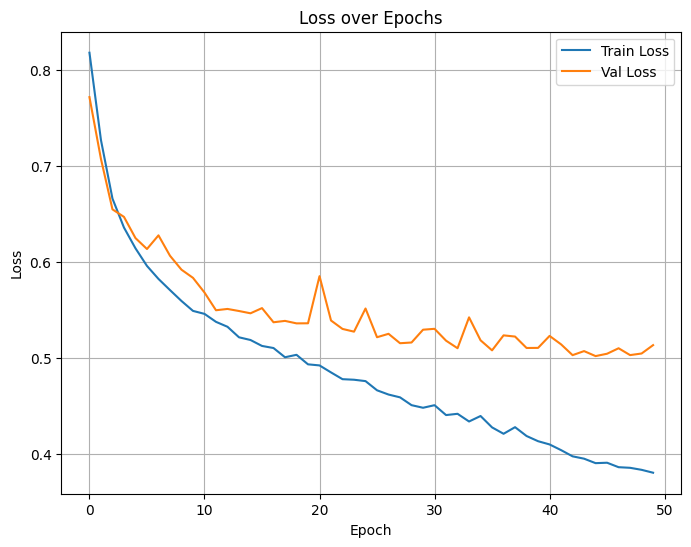

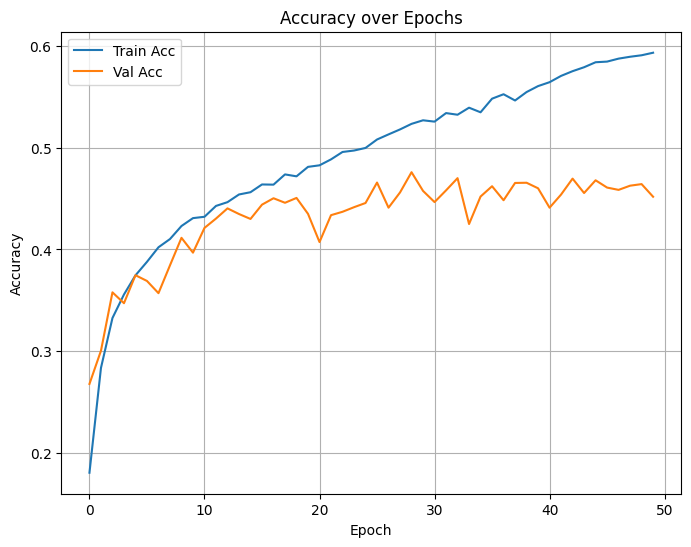

In [12]:


writer = SummaryWriter(log_dir="runs/experiment1")

labels = {
      0: "No Data",
      1: "Natural Vegetation",
      2: "Forest",
      3: "Corn",
      4: "Soybeans",
      5: "Wetlands",
      6: "Developed Barren",
      7: "Open Water",
      8: "Winter Wheat",
      9: "Alfalfa",
      10: "Fallow Idle Cropland",
      11: "Cotton",
      12: "Sorghum",
      13: "Other"
  }

train_losses, train_accs, train_ious, train_mious, train_dices = [], [], [], [], []
val_losses,   val_accs,   val_ious,   val_mious,  val_dices = [], [], [], [], []
best_val_acc = 0.0
best_epoch     = 0
best_model_wts = None

for epoch in range(EPOCHS):
    model.train()
    train_loss_sum = train_acc_sum = train_iou_sum = train_dice_sum = train_miou_sum = 0.0
    accuracy.reset(); iou.reset(); dice.reset(); miou.reset()

    ### ——— TRAIN ———
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, masks = images.to(DEVICE), masks.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, dim=1)

        accuracy.update(preds, masks)
        iou      .update(preds, masks)
        dice     .update(preds, masks)
        miou     .update(preds, masks)

        train_loss_sum  += loss.item()

    # Average metrics
    train_losses.append(train_loss_sum / len(train_loader))
    train_accs  .append(accuracy.compute().item())
    train_ious  .append(iou.compute().item())
    train_dices .append(dice.compute().item())
    train_mious .append(miou.compute().item())

    writer.add_scalar('Loss/train', train_losses[-1], epoch)
    writer.add_scalar('Accuracy/train', train_accs[-1], epoch)
    writer.add_scalar('IoU/train', train_ious[-1], epoch)
    writer.add_scalar('Dice/train', train_dices[-1], epoch)
    writer.add_scalar('mIoU/train', train_mious[-1], epoch)


    tqdm.write(
        f"[Epoch {epoch:>2d}] "
        f"Loss:  {train_losses[-1]:.4f}, "
        f"Acc:   {train_accs[-1]:.4f}, "
        f"IoU:   {train_ious[-1]:.4f}, "
        f"Dice:  {train_dices[-1]:.4f}, "
        f"mIoU:  {train_mious[-1]:.4f}"
    )

    ### ——— VALIDATION ———
    model.eval()
    val_loss_sum = val_acc_sum = val_iou_sum = val_dice_sum = val_miou_sum = 0.0
    accuracy.reset(); iou.reset(); dice.reset(); miou.reset()

    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]"):
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, masks)

            preds = torch.argmax(outputs, dim=1)

            accuracy.update(preds, masks)
            iou      .update(preds, masks)
            dice     .update(preds, masks)
            miou     .update(preds, masks)

            val_loss_sum  += loss.item()

    # Average metrics
    val_acc = accuracy.compute().item()
    val_losses.append(val_loss_sum / len(val_loader))
    val_accs  .append(val_acc)
    val_ious  .append(iou.compute().item())
    val_dices .append(dice.compute().item())
    val_mious .append(miou.compute().item())

    # Log to TensorBoard
    writer.add_scalar('Loss/val', val_losses[-1], epoch)
    writer.add_scalar('Accuracy/val', val_accs[-1], epoch)
    writer.add_scalar('IoU/val', val_ious[-1], epoch)
    writer.add_scalar('Dice/val', val_dices[-1], epoch)
    writer.add_scalar('mIoU/val', val_mious[-1], epoch)

    tqdm.write(
        f"[Epoch {epoch:>2d}] "
        f"Loss: {val_losses[-1]:.4f}, "
        f"Acc: {val_accs[-1]:.4f}, "
        f"IoU: {val_ious[-1]:.4f}, "
        f"Dice: {val_dices[-1]:.4f}, "
        f"mIoU: {val_mious[-1]:.4f}"
    )

    # Scheduler step on validation loss
    scheduler.step(val_losses[-1])

    if val_acc > best_val_acc:
        best_val_acc   = val_acc
        best_epoch     = epoch + 1
        best_model_wts = copy.deepcopy(model.state_dict())


model.load_state_dict(best_model_wts)

# After training, plot metrics separately
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses,   label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(train_accs,  label='Train Acc')
plt.plot(val_accs,    label='Val Acc')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Close TensorBoard writer
writer.close()


Saved Loss plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/DeepLabV3+/graphs/deeplabv3+_resnet34_None_32bs_50ep_lr1e-04_loss_20250515-213919_normalized_trevesky.png


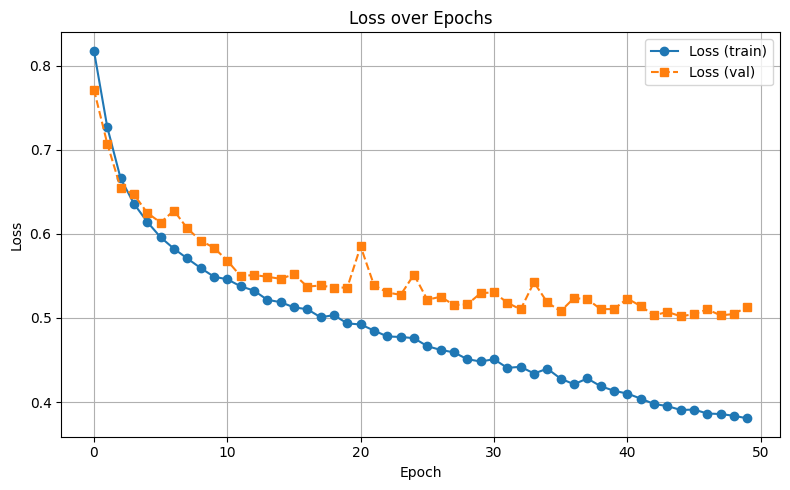

Saved Accuracy plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/DeepLabV3+/graphs/deeplabv3+_resnet34_None_32bs_50ep_lr1e-04_accuracy_20250515-213919_normalized_trevesky.png


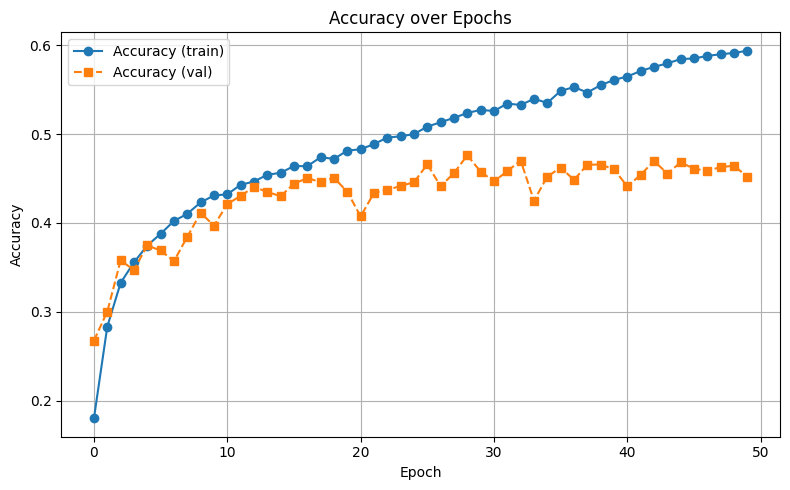

Saved Iou plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/DeepLabV3+/graphs/deeplabv3+_resnet34_None_32bs_50ep_lr1e-04_iou_20250515-213919_normalized_trevesky.png


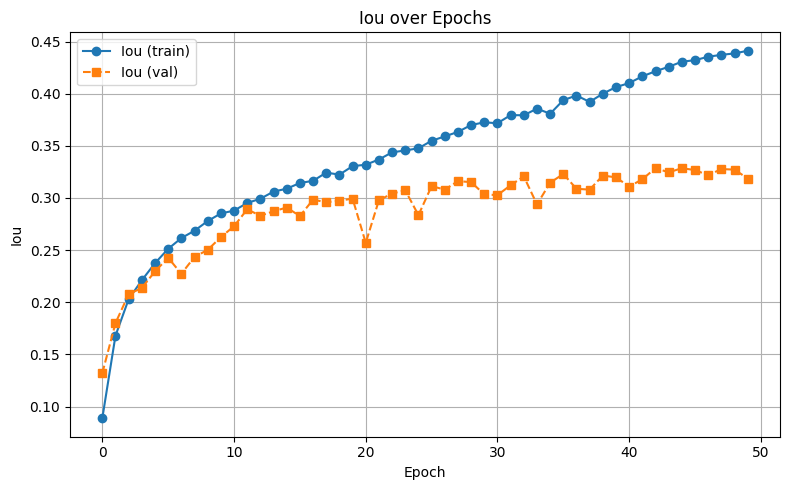

Saved Dice plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/DeepLabV3+/graphs/deeplabv3+_resnet34_None_32bs_50ep_lr1e-04_dice_20250515-213919_normalized_trevesky.png


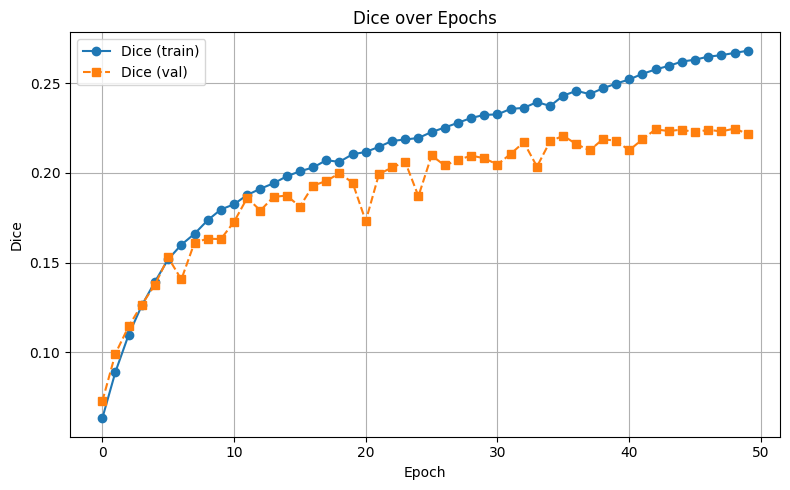

Saved Miou plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/DeepLabV3+/graphs/deeplabv3+_resnet34_None_32bs_50ep_lr1e-04_miou_20250515-213919_normalized_trevesky.png


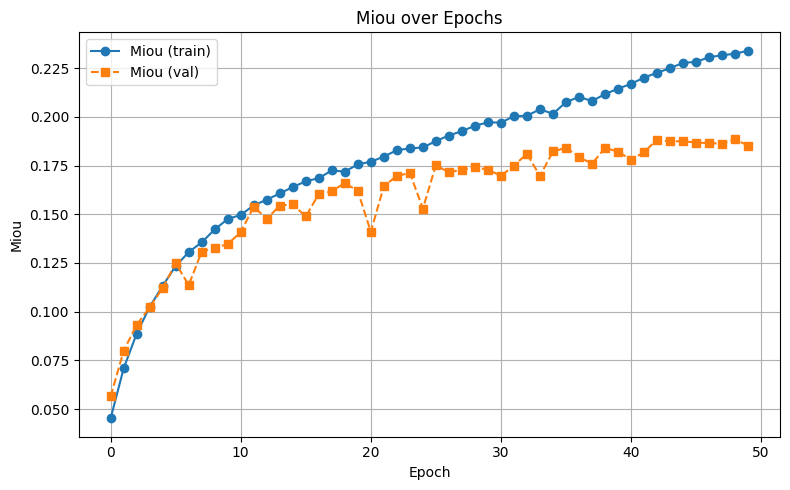

In [13]:
timestamp = time.strftime("%Y%m%d-%H%M%S")

all_metrics = {
    'loss':  (train_losses, val_losses),
    'accuracy': (train_accs, val_accs),
    'iou':    (train_ious, val_ious),
    'dice':   (train_dices, val_dices),
    'miou':   (train_mious, val_mious),
}

for metric_name, (train_vals, val_vals) in all_metrics.items():
    plt.figure(figsize=(8, 5))
    plt.plot(train_vals, marker='o', linestyle='-', label=f'{metric_name.title()} (train)')
    plt.plot(val_vals,   marker='s', linestyle='--', label=f'{metric_name.title()} (val)')
    plt.title(f'{metric_name.title()} over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name.title())
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # build a descriptive filename
    filename = (
        f"deeplabv3+_{ENCODER_NAME}_{ENCODER_WEIGHTS}_"
        f"{BATCH_SIZE}bs_{EPOCHS}ep_lr{LEARNING_RATE:.0e}_"
        f"{metric_name}_{timestamp}_normalized_trevesky.png"
    )
    save_path = os.path.join(UNET_GRAPH_FOLDER, filename)

    # save and show
    plt.savefig(save_path, dpi=300)
    print(f"Saved {metric_name.title()} plot to: {save_path}")
    plt.show()

In [14]:

os.makedirs(UNET_MODEL_FOLDER, exist_ok=True)

model_filename = (
    f"deeplabv3+_{ENCODER_NAME}_{ENCODER_WEIGHTS}_"
    f"{BATCH_SIZE}bs_{EPOCHS}ep_"
    f"lr{LEARNING_RATE:.0e}_normalized_trevesky.pth"
)

model_path = os.path.join(UNET_MODEL_FOLDER, model_filename)


torch.save(model.state_dict(), model_path)
print(f"Saved model checkpoint to: {model_path}")


Saved model checkpoint to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/DeepLabV3+/models/deeplabv3+_resnet34_None_32bs_50ep_lr1e-04_normalized_trevesky.pth


In [15]:
os.makedirs(UNET_METRICS_FOLDER, exist_ok=True)

# Build a DataFrame with both train & val metrics
metrics_df = pd.DataFrame({
    'Epoch':        list(range(1, len(train_losses) + 1)),
    'train_Loss':   train_losses,
    'train_Acc':    train_accs,
    'train_IoU':    train_ious,
    'train_Dice':   train_dices,
    'train_mIoU':   train_mious,
    'val_Loss':     val_losses,
    'val_Acc':      val_accs,
    'val_IoU':      val_ious,
    'val_Dice':     val_dices,
    'val_mIoU':     val_mious,
})

# Descriptive filename using your hyper-params
csv_filename = (
    f"deeplabv3+_{ENCODER_NAME}_{ENCODER_WEIGHTS}_"
    f"{BATCH_SIZE}bs_{EPOCHS}ep_lr{LEARNING_RATE:.0e}_normalized_trevesky_metrics.csv"
)
csv_path = os.path.join(UNET_METRICS_FOLDER, csv_filename)

# Save!
metrics_df.to_csv(csv_path, index=False)
print(f"Saved all train/val metrics to: {csv_path}")


Saved all train/val metrics to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/DeepLabV3+/metrics/deeplabv3+_resnet34_None_32bs_50ep_lr1e-04_normalized_trevesky_metrics.csv
